In [27]:
import sys
sys.path.append("../")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd
from scipy.stats import median_abs_deviation

from experiments import RandomWalkDiffusionExperiment
from models import RandomWalkDiffusion
from priors import sample_scale

In [35]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = False
FIT_MODEL = False

NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'
ALPHA = 0.6
PARAMETER_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
PARAMETER_NAMES = [r'$v$', r'$a$', r'$\tau$']

FONT_SIZE_1 = 24
FONT_SIZE_2 = 20
FONT_SIZE_3 = 16

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

## Neural Experiment

In [3]:
model = RandomWalkDiffusion()
neural_experiment = RandomWalkDiffusionExperiment(model)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 100, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 100, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/stan_benchmark/history_50.pkl.
INFO:root:Networks loaded from ../checkpoints/stan_benchmark/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Training

In [4]:
if TRAIN_NETWORKS:
    history = neural_experiment.run(
        epochs=50, 
        iterations_per_epoch=1000, 
        batch_size=8
    )
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

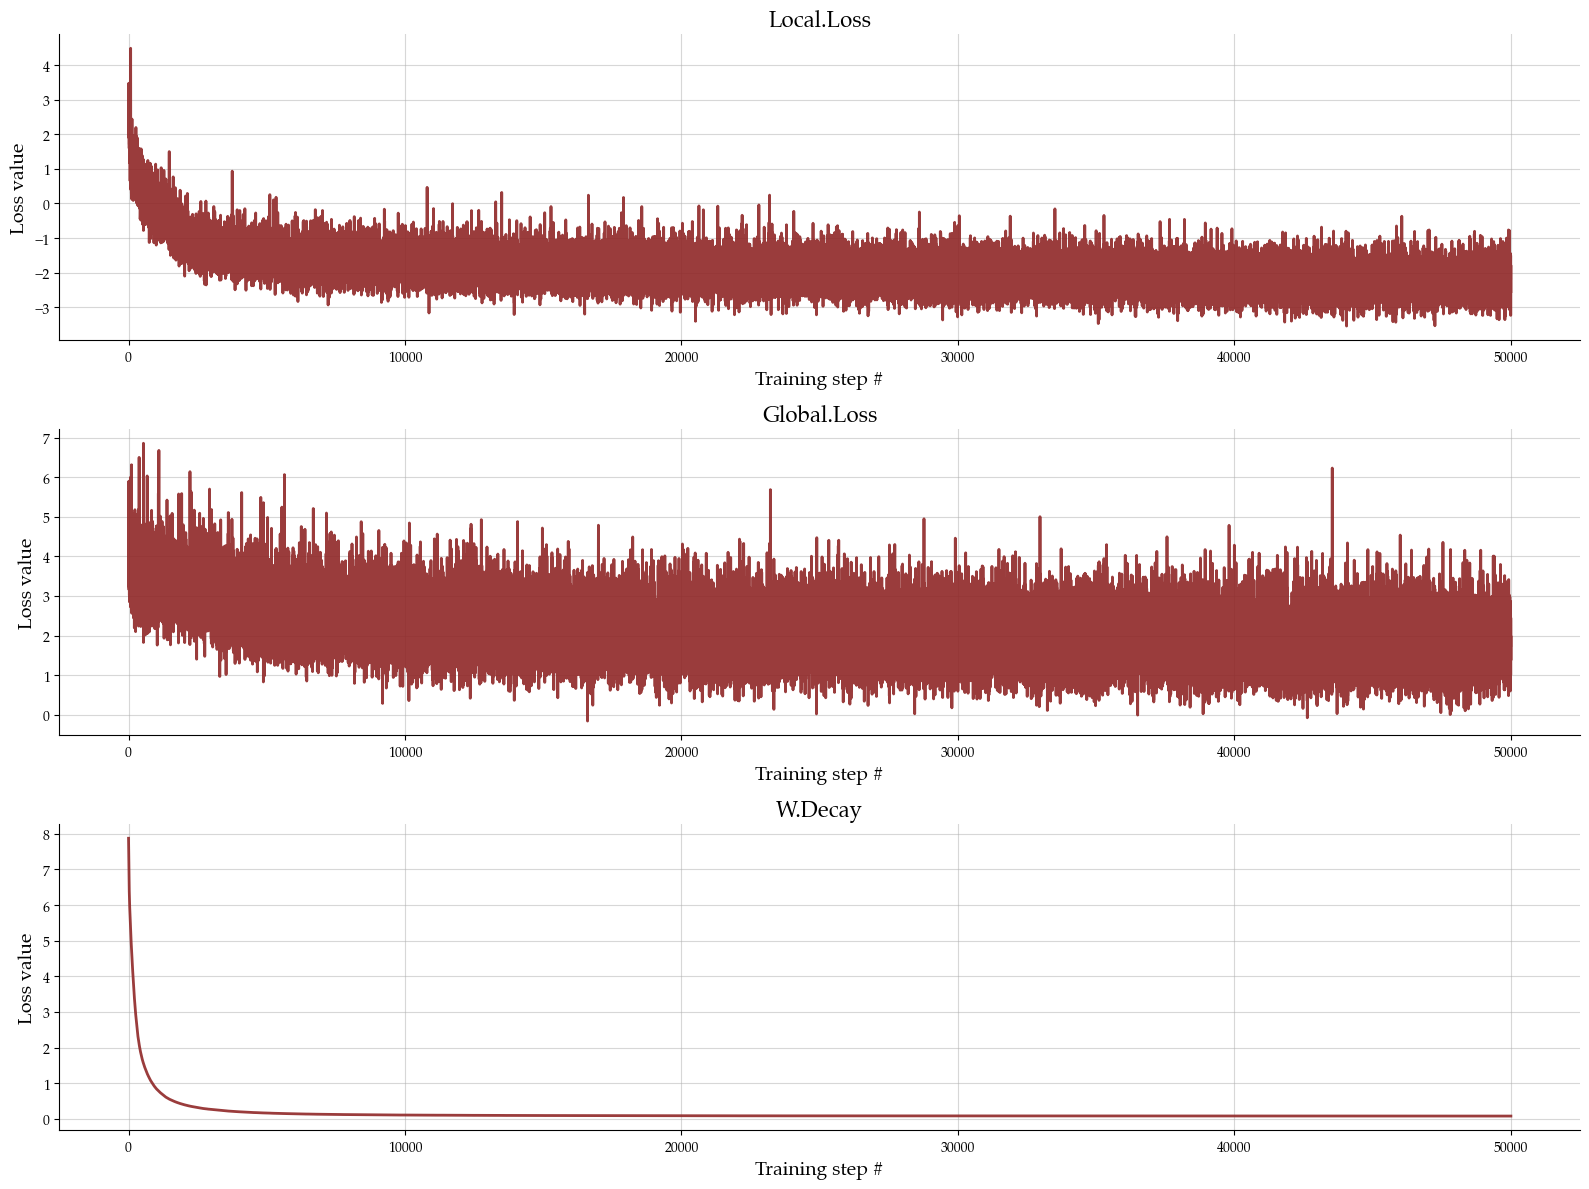

In [5]:
f = beef.diagnostics.plot_losses(history)

## Fitting

In [6]:
# read simulation data
simulation_output = pd.read_pickle('../data/static_dm_data_100.pkl')
sim_data = simulation_output['rt']
true_param = simulation_output['theta']

N_SIM = sim_data.shape[0]
NUM_STEPS = sim_data.shape[1]
N_SAMPLES = 4000

In [7]:
if FIT_MODEL:
    neural_post_samples = np.zeros((N_SIM, NUM_STEPS, N_SAMPLES, 3))
    for i in range(N_SIM):
        neural_post_samples[i] = neural_experiment.amortizer.sample(
            {"summary_conditions": sim_data[i:i+1]},
            N_SAMPLES
            )['local_samples']
    np.save('../data/neural_post_samples.npy', neural_post_samples)
else:
    neural_post_samples = np.load('../data/neural_post_samples.npy')

In [8]:
neural_post_samples = neural_post_samples * model.local_prior_stds + model.local_prior_means

## Evaluation

In [28]:
# read and prepare posteriors obtained with stan
stan_posteriors = np.load('../data/dynamic_stan_posteriors_100.npy')
# get posterior means
neural_post_means = neural_post_samples.mean(axis=2)
stan_post_means = stan_posteriors.mean(axis=2)
# calculate absolute error between posterior means and true parameter
neural_post_abs_error = np.empty((N_SIM, NUM_STEPS, 3))
stan_post_abs_error = np.empty((N_SIM, NUM_STEPS, 3))
for i in range(N_SIM):
    neural_post_abs_error[i] = np.abs(neural_post_means[i] - true_param[i])
    stan_post_abs_error[i] = np.abs(stan_post_means[i] - true_param[i])
# summarize absolute errors
neural_post_abs_error_mean = np.median(neural_post_abs_error, axis=0)
neural_post_abs_error_std = median_abs_deviation(neural_post_abs_error, axis=0)
stan_post_abs_error_mean = stan_post_abs_error.mean(axis=0)
stan_post_abs_error_std = median_abs_deviation(stan_post_abs_error, axis=0)
# get mean and std of posterior stds
neural_post_std_means = np.median(neural_post_samples.std(axis=2), axis=0)
neural_post_std_stds = median_abs_deviation(neural_post_samples.std(axis=2), axis=0)
stan_post_std_means = np.median(stan_posteriors.std(axis=2), axis=0)
stan_post_std_stds = median_abs_deviation(stan_posteriors.std(axis=2), axis=0)

In [30]:
neural_post_abs_error_std.shape


(100, 3)

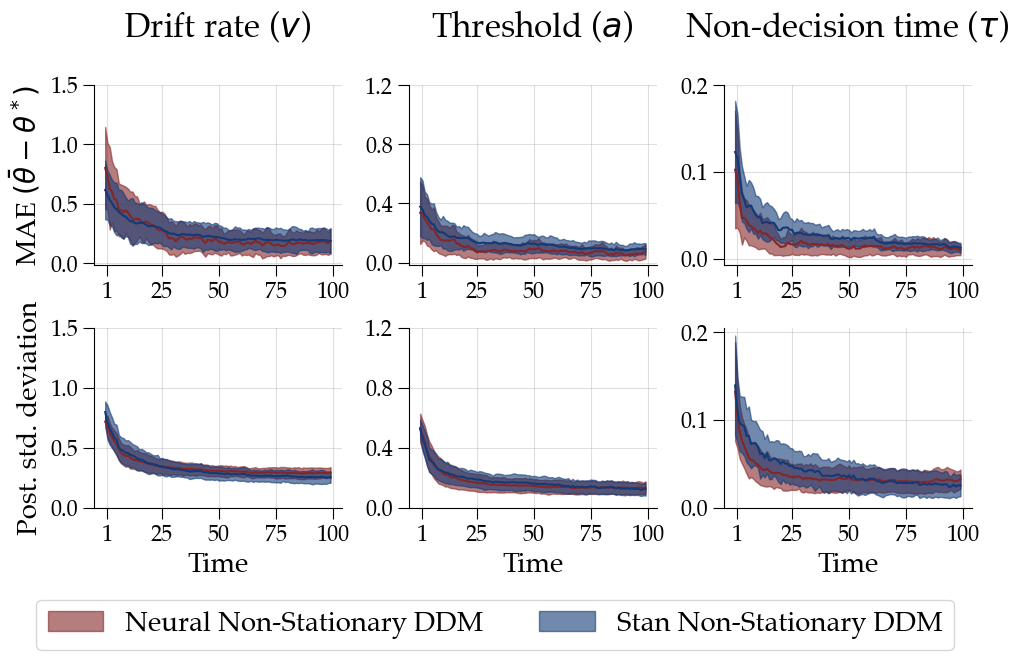

In [37]:
f, axarr = plt.subplots(2, 3, figsize=(10, 6))
for i, ax in enumerate(axarr.flat):
    if i < 3:
        # plot neural results
        ax.plot(np.arange(NUM_STEPS), neural_post_abs_error_mean[:, i], color=NEURAL_COLOR)
        ax.fill_between(
            np.arange(NUM_STEPS),
            neural_post_abs_error_mean[:, i] - neural_post_abs_error_std[:, i],
            neural_post_abs_error_mean[:, i] + neural_post_abs_error_std[:, i],
            color=NEURAL_COLOR, alpha=ALPHA, label='Neural Non-Stationary DDM'
        )
        # plot dynamic stan
        ax.plot(np.arange(NUM_STEPS), stan_post_abs_error_mean[:, i], color=COMPARISON_COLOR)
        ax.fill_between(
            np.arange(NUM_STEPS),
            stan_post_abs_error_mean[:, i] - stan_post_abs_error_std[:, i],
            stan_post_abs_error_mean[:, i] + stan_post_abs_error_std[:, i],
            color=COMPARISON_COLOR, alpha=ALPHA, label='Stan Non-Stationary DDM'
        )
        # set titles and labels
        ax.set_title(
            PARAMETER_LABELS[i] + ' ({})'.format(PARAMETER_NAMES[i]) + "\n", fontsize=FONT_SIZE_1)
        if i == 0:
            ax.set_ylabel(r'MAE $(\bar{\theta} - \theta^*)$', fontsize=FONT_SIZE_2)
        # if i == 2:
        #     ax.legend(fontsize=FONT_SIZE_2, loc='best', fancybox=False, shadow=False)

    else:
        # plot neural results
        ax.plot(np.arange(NUM_STEPS), neural_post_std_means[:, i-3], color=NEURAL_COLOR)
        ax.fill_between(
            np.arange(NUM_STEPS),
            neural_post_std_means[:, i-3] - neural_post_std_stds[:, i-3],
            neural_post_std_means[:, i-3] + neural_post_std_stds[:, i-3],
            color=NEURAL_COLOR, alpha=ALPHA, label='Neural Non-Stationary DM'
        )
        # plot dynamic stan
        ax.plot(np.arange(NUM_STEPS), stan_post_std_means[:, i-3], color=COMPARISON_COLOR)
        ax.fill_between(
            np.arange(NUM_STEPS),
            stan_post_std_means[:, i-3] - stan_post_std_stds[:, i-3],
            stan_post_std_means[:, i-3] + stan_post_std_stds[:, i-3],
            color=COMPARISON_COLOR, alpha=ALPHA, label='Stan Non-Stationary DM'
        )
    
        ax.set_xlabel('Time', fontsize=FONT_SIZE_2)
        if i == 3:
            ax.set_ylabel('Post. std. deviation', fontsize=FONT_SIZE_2)

    if i == 0 or i == 3:
        ax.set_yticks([0.0, 0.5, 1.0, 1.5])
    elif i == 1 or i == 4:
        ax.set_yticks([0.0, 0.4, 0.8, 1.2])
    else:
        ax.set_yticks([0.0, 0.1, 0.2])

    if i == 0:
        f.subplots_adjust(hspace=0.5)
        f.legend(
            bbox_to_anchor=(0.5, -0.05),
            fontsize=FONT_SIZE_2,
            loc="center",
            ncol=3
            )

    ax.set_xticks([1, 25, 50, 75, 100])
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3, length=8)

    ax.set_axisbelow(True)
    ax.grid(alpha=0.4)

sns.despine()
plt.tight_layout()
plt.savefig('../plots/stan_benchmark.png', dpi=300, bbox_inches='tight')